# Import external libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import re
import random
import os
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns # Plot statistical data such as Annotated heatmaps
import datetime
import tensorflow as tf
from keras.layers import Embedding
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc
import difflib
import Levenshtein
from Levenshtein import distance
from sklearn.linear_model import LinearRegression

from remove_given_code_from_student_solution import remove_given_code_from_df

2023-02-06 16:47:21.301516: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 16:47:21.520616: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-06 16:47:21.520632: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-06 16:47:21.554629: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-06 16:47:22.178222: W tensorflow/stream_executor/platform/de

In [2]:
PATH_LABLED_SPLIT = "/home/erik/TU/ni/plagiarism_detection_tool/data/labled/"
PATH_LABLED = "/home/erik/TU/ni/plagiate_labeltool/data/labled/"
PATH_TEMPLATE = "/home/erik/TU/ni/plagiate_labeltool/data/code_templates/"
MY_PATH = '/home/erik/TU/ni/Source-Code-Plagiarism-Detection/data'

# Preprocessing

## Create and save split data


In [3]:
def split_and_save_data(df, suffix, random_state=42):
    for i in range(len(df)):
        if random.random() > 0.5:
            df.at[i, 'code1'], df.at[i, 'code2'] = df.at[i, 'code2'], df.at[i, 'code1']
    X_temp, X_test, y_temp, y_test = train_test_split(df[['code1', 'code2', 'type']], df['label'], test_size=0.2, random_state=random_state)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=random_state)
    pd.concat([X_train,y_train], axis=1).to_csv(f'{PATH_LABLED_SPLIT}thesis/train_data_{suffix}.csv',sep=',',index=False)
    pd.concat([X_val,y_val], axis=1).to_csv(f'{PATH_LABLED_SPLIT}thesis/val_data_{suffix}.csv',sep=',',index=False)
    pd.concat([X_test,y_test], axis=1).to_csv(f'{PATH_LABLED_SPLIT}thesis/test_data_{suffix}.csv',sep=',',index=False)
    print(f'y_train plagiate: {np.count_nonzero(y_train.astype(int) == 1)}; y_train not plagiate: {np.count_nonzero(y_train.astype(int) == 0)}')
    print(f'y_test plagiate: {np.count_nonzero(y_test.astype(int) == 1)}; y_test not plagiate: {np.count_nonzero(y_test.astype(int) == 0)}')
    print(f'y_val plagiate: {np.count_nonzero(y_val.astype(int) == 1)}; y_val not plagiate: {np.count_nonzero(y_val.astype(int) == 0)}')

def open_split_and_save_data(semester, ha, prog_lang, path=None, suffix=''):
    if path is None:
        path = PATH_LABLED+f'PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_lang}-Antworten'
    df_labled = pd.read_csv(f'{path}_labled{suffix}.csv')
    try:
        df_labled = df_labled.drop('Unnamed: 0', axis=1)
    except KeyError:
        pass
    # given code must be removed in labled.csv, already happend for plagiate.csv
    df_labled = remove_given_code_from_df(df=df_labled)
    try:
        df_plagiate = pd.read_csv(f'{path}_plagiate{suffix}.csv')
        try:
            df_plagiate = df_plagiate.drop('Unnamed: 0', axis=1)
        except KeyError:
            pass
    except FileNotFoundError:
        if path is None:
            print(f'No plagiate file found for {semester} {ha} {prog_lang}')
        else:
            print(f'No plagiate file found for {path}_plagiate{suffix}.csv')
        df_plagiate = None
    df = pd.concat([df_labled,df_plagiate], ignore_index=True)
    split_and_save_data(df, suffix)
    return df_labled, df_plagiate

In [4]:
# open all csvs in labled folder and check if they contain copy and paste plagiate
def open_all_labled_csvs(path='../../plagiarism_detection_tool/data/labled/2023_01_02'):
    df = pd.DataFrame()
    for filename in os.listdir(path):
        if filename.endswith(".csv") and filename.startswith('PPR'):
            print(filename)
            df_tmp = pd.read_csv(f'{path}/{filename}', delimiter=',')
            df = pd.concat([df, df_tmp], ignore_index=True)
        else:
            continue
    count_copy_and_paste_plagiate = len(df[df['lastname1'] == df['lastname2']])
    count = len(df)
    print(f'len(df): {count}')
    print(f'count_copy_and_paste_plagiate: {count_copy_and_paste_plagiate}')
    print(f'len(df) - count_copy_and_paste_plagiate: {count - count_copy_and_paste_plagiate}')
    return df

# df = open_all_labled_csvs()

In [5]:
def save_csv_smaller_label(df, label, suffix):
    df = df[df['label'] < label]
    df.to_csv(f'{PATH_LABLED_SPLIT}/2023_01_02/all_labled_data_{suffix}.csv', sep=',', index=False)    

# save_csv_smaller_label(df, 0.4, 'smaller_0.4')

In [6]:
def set_non_plagiate_and_resave_csv(suffix):
    df = pd.read_csv(f'{PATH_LABLED_SPLIT}/2023_01_02/all_labled_data_{suffix}.csv', delimiter=',')
    df['label'] = 0
    df.to_csv(f'{PATH_LABLED_SPLIT}/2023_01_02/all_labled_data_{suffix}.csv', sep=',', index=False)

# set_non_plagiate_and_resave_csv('smaller_0.7')

In [7]:
def save_plagiate_in_new_csv(suffix):
    df = pd.read_csv(f'{PATH_LABLED_SPLIT}/2023_01_02/all_labled_data_{suffix}.csv', delimiter=',')
    df_plagiate = df[df['label'] > 0.5]
    df_plagiate.to_csv(f'{PATH_LABLED_SPLIT}/2023_01_02/all_plagiate_data_{suffix}.csv', sep=',', index=False)

### Load split data


In [8]:
def read_and_split_data(data_type='train_data_', suffix='_copy_and_paste'):
    data = pd.read_csv(PATH_LABLED_SPLIT + f'thesis/{data_type}{suffix}.csv',sep=',')
    return data[['code1','code2']], data[['label']] 

# suffix = '_data_smaller_0.7'
# DATASET = 'smaller_0.7'
# # suffix = 'WS2021_HA9'
# # suffix = 'HA9'
# X_train, y_train = read_and_split_data('train_data_', suffix)
# X_val, y_val = read_and_split_data('val_data_', suffix)
# X_test, y_test = read_and_split_data('test_data_', suffix)

## Preprocess the pairs for the models


In [9]:
def striphtml(data): 
    return re.sub('<.*?>', ' ', str(data)) 

def stripunc(data): 
    return re.sub('[^A-Za-z%\._\[\]]+', ' ', str(data), flags=re.MULTILINE|re.DOTALL) 

In [10]:
def preprocess_student_pairs(df): 
    df['code1_strip'] = df[['code1']].apply(lambda x:striphtml(stripunc((x[0]))).lower(), axis=1)
    df['code2_strip'] = df[['code2']].apply(lambda x:striphtml(stripunc((x[0]))).lower(), axis=1)
    return df

In [14]:
# %%capture
# preprocess_student_pairs(X_train)
# preprocess_student_pairs(X_val)
# preprocess_student_pairs(X_test)


# TextVectorization Model

In [11]:
THESIS_PATH = '/home/erik/TU/ni/Source-Code-Plagiarism-Detection/data/thesis/'

def train_vectorize_layer(vectorize_layer, X_train):
    vectorize_layer.adapt(X_train['code1_strip'].values)
    vectorize_layer.adapt(X_train['code2_strip'].values)

def textvectorization_model(tf_idf='tf_idf', max_vocab_len=1000, embedding_dim=64, dropout=0.2, rnn_units=64, dense_units=32, lr=0.001):
    if tf_idf == 'tf_idf':
        vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=max_vocab_len, output_mode=tf_idf, idf_weights=True)
    elif tf_idf == 'tf':
        vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=max_vocab_len, output_mode='tf_idf', idf_weights=False)
    else:
        vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=max_vocab_len, output_mode='int')
    train_vectorize_layer(vectorize_layer, X_train)
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(2,), dtype=tf.string),
        tf.keras.layers.Lambda(lambda x: tf.strings.reduce_join(x, axis=1, separator=' '), output_shape=(1,)),
        vectorize_layer,
        tf.keras.layers.Embedding(max_vocab_len, embedding_dim, mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_units)),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid'),
    ])
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])
    return model


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-4, restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


## Use GridSearchCV to find the best parameters

In [17]:
# tf_idf='tf_idf'
# dropout=0.2
# max_vocab_len=1000
# embedding_dim=16
# rnn_units=16
# dense_units=32
# lr = 0.01

# # create a kerasclassifier and make gridsearch
# keras = KerasRegressor(build_fn=textvectorization_model, tf_idf=tf_idf, max_vocab_len=max_vocab_len, embedding_dim=embedding_dim, dropout=dropout, rnn_units=rnn_units, dense_units=dense_units, lr=lr, epochs=50, batch_size=32, verbose=1)
# param_grid = dict(tf_idf=['tf_idf'], dropout=[0.2, 0.4], max_vocab_len=[1000], embedding_dim=[16], rnn_units=[16], dense_units=[16], lr=[0.1, 0.01, 0.01])
# grid = GridSearchCV(estimator=keras, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1)

In [18]:
# # self written grid search
# results = []
# for tf_idf in ['tf_idf']:
#     for dropout in [0.2]:#, 0.4]:
#         for max_vocab_len in [1000]:
#             for embedding_dim in [16]:
#                 for rnn_units in [16]:
#                     for dense_units in [16]:
#                         for lr in [0.1, 0.01, 0.001]:
#                             model = textvectorization_model(tf_idf=tf_idf, max_vocab_len=max_vocab_len, embedding_dim=embedding_dim, dropout=dropout, rnn_units=rnn_units, dense_units=dense_units, lr=lr)
#                             # model.load_weights(THESIS_PATH + 'textvectorization_model_{}_{}_{}_{}_{}_{}_{}.tf'.format(tf_idf, dropout, max_vocab_len, embedding_dim, rnn_units, dense_units, lr))
#                             training_history = model.fit(X_train[['code1_strip','code2_strip']], y_train, validation_data=(X_val[['code1_strip', 'code2_strip']], y_val), epochs=50, verbose=1, callbacks=[early_stopping, reduce_lr])
#                             # model.save(THESIS_PATH + 'textvectorization_model_{}_{}_{}_{}_{}_{}_{}.tf'.format(tf_idf, dropout, max_vocab_len, embedding_dim, rnn_units, dense_units, lr))
#                             print('tf_idf: {}, dropout: {}, max_vocab_len: {}, embedding_dim: {}, rnn_units: {}, dense_units: {}, lr: {}'.format(tf_idf, dropout, max_vocab_len, embedding_dim, rnn_units, dense_units, lr))
#                             # save the accuracy and loss of the model from the validation set
#                             results.append([tf_idf, dropout, max_vocab_len, embedding_dim, rnn_units, dense_units, lr, training_history.history['val_accuracy'][-1], training_history.history['val_loss'][-1]])

# # tf_idf: tf_idf, dropout: 0.2, max_vocab_len: 1000, embedding_dim: 16, rnn_units: 16, dense_units: 16, lr: 0.1
# # 96/96 [==============================] - 29s 300ms/step - loss: 0.0137 - accuracy: 0.9944 - val_loss: 0.0025 - val_accuracy: 1.0000 - lr: 0.0200
# # tf_idf: tf_idf, dropout: 0.2, max_vocab_len: 1000, embedding_dim: 16, rnn_units: 16, dense_units: 16, lr: 0.01
# # 96/96 [==============================] - 29s 303ms/step - loss: 1.0175e-04 - accuracy: 1.0000 - val_loss: 0.0070 - val_accuracy: 0.9987 - lr: 0.0100
# # tf_idf: tf_idf, dropout: 0.2, max_vocab_len: 1000, embedding_dim: 16, rnn_units: 16, dense_units: 16, lr: 0.001
# # 96/96 [==============================] - 29s 306ms/step - loss: 6.5587e-05 - accuracy: 1.0000 - val_loss: 0.0075 - val_accuracy: 0.9974 - lr: 0.0010


In [12]:
suffix = '_data_smaller_0.4'
X_train, y_train = read_and_split_data('train_data_', suffix)
X_val, y_val = read_and_split_data('val_data_', suffix)
X_test, y_test = read_and_split_data('test_data_', suffix)

preprocess_student_pairs(X_train)
preprocess_student_pairs(X_val)
preprocess_student_pairs(X_test)
model = textvectorization_model(tf_idf='tf_idf', max_vocab_len=1000, embedding_dim=16, dropout=0.2, rnn_units=16, dense_units=16, lr=0.1)
history = model.fit(X_train[['code1_strip','code2_strip']], y_train, validation_data=(X_val[['code1_strip', 'code2_strip']], y_val), epochs=50, verbose=1, callbacks=[early_stopping, reduce_lr])


2023-02-06 16:48:26.578049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-06 16:48:26.578295: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-06 16:48:26.578307: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (erik-MS-7C56): /proc/driver/nvidia/version does not exist
2023-02-06 16:48:26.578452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
57/57 [==============================] - 21s 301ms/step - loss: 0.4903 - accuracy: 0.7761 - val_loss: 0.4289 - val_accuracy: 0.8200 - lr: 0.1000
Epoch 2/50
57/57 [==============================] - 16s 278ms/step - loss: 0.3290 - accuracy: 0.8639 - val_loss: 0.4138 - val_accuracy: 0.8378 - lr: 0.1000
Epoch 3/50
57/57 [==============================] - 16s 282ms/step - loss: 0.3360 - accuracy: 0.8672 - val_loss: 0.3527 - val_accuracy: 0.8578 - lr: 0.1000
Epoch 4/50
57/57 [==============================] - 16s 278ms/step - loss: 0.2866 - accuracy: 0.8767 - val_loss: 0.3881 - val_accuracy: 0.8467 - lr: 0.1000
Epoch 5/50
57/57 [==============================] - 17s 294ms/step - loss: 0.2970 - accuracy: 0.8800 - val_loss: 0.4239 - val_accuracy: 0.8733 - lr: 0.1000
Epoch 6/50
57/57 [==============================] - 16s 285ms/step - loss: 0.3205 - accuracy: 0.8667 - val_loss: 0.3170 - val_accuracy: 0.8733 - lr: 0.1000
Epoch 7/50
57/57 [==============================] - 16s 286ms/st

In [20]:
# # evaluate the model
# loss, accuracy = model.evaluate(X_val[['code1_strip', 'code2_strip']], y_val, verbose=1)
# loss, accuracy = model.evaluate(X_test[['code1_strip', 'code2_strip']], y_test, verbose=1)

# #save the model
# # model.save(THESIS_PATH + 'thesis/textvectorization_model_{}_{}_{}_{}_{}_{}_{}_best_parameter.tf'.format(tf_idf, dropout, max_vocab_len, embedding_dim, rnn_units, dense_units, lr))

In [15]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


## Plot Training History

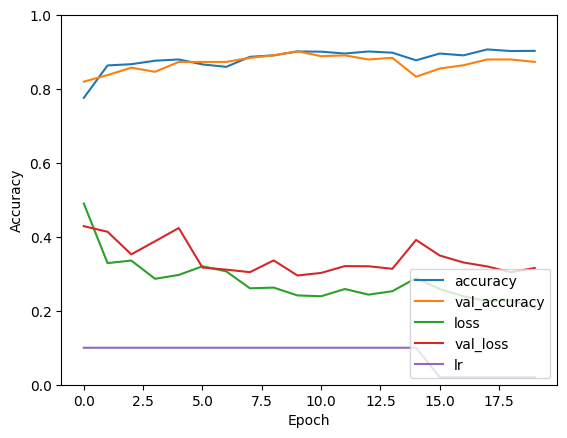

In [17]:
def plot_training_history(training_history, path):
    plt.plot(training_history.history['accuracy'], label='accuracy')
    plt.plot(training_history.history['val_accuracy'], label = 'val_accuracy')
    plt.plot(training_history.history['loss'], label='loss')
    plt.plot(training_history.history['val_loss'], label = 'val_loss')
    plt.plot(training_history.history['lr'], label = 'lr')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.savefig(path)
    plt.show()

plot_training_history(history, THESIS_PATH + 'smaller_0.4/textvectorization_model_{}_{}_{}_{}_{}_{}_{}2.png'.format('tf-idf', 0.2, 1000, 16, 16, 16, 0.2))

## Plot Model

In [23]:
# load textvectorization_model from dataset smaller_0.4
# textvectorization_model = tf.keras.models.load_model(THESIS_PATH + 'smaller_0.4/textvectorization_model.tf')
# model.summary()


In [24]:
# plot_model(textvectorization_model, to_file=THESIS_PATH + 'textvectorization_model_new.png', show_shapes=True, show_layer_names=False)

# Evaluation

## Confusion Matrix

In [21]:
def show_confusion_matrix(y_test, predictions, MAIN_FOLDER, model_name, title):
    matrix = metrics.confusion_matrix(y_test, predictions)
    LABELS = ["Not Similar", "Similar"]
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix for "+ model_name +"\n with " + title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label : acc = " + str(round(metrics.accuracy_score(y_test, predictions), 2)))
    path = MAIN_FOLDER
    plt.savefig(path + 'confusion_matrix_{}.svg'.format(datetime.datetime.now().isoformat()))
    plt.show()

In [22]:
def calculate_confusion_matrix(predictions, y_test, MAIN_FOLDER, model_name, title):
    y_pred = np.array([round(x) for x in predictions],dtype='int64')
    y_test_flatted = np.array([round(x) for x in y_test['label']],dtype='int64')
    # y_test_flatted = np.array(y_test['label'], dtype='float64').flatten()
    incorrects = np.nonzero(y_pred != y_test_flatted)
    print("Incorrectly predicted: {} from total {} == {:.3f}%".format(len(incorrects[0]), len(y_test_flatted), len(incorrects[0])/len(y_test_flatted)))
    show_confusion_matrix(y_test_flatted, y_pred, MAIN_FOLDER, model_name, title)

## Predictions on test dataset with difflib, levenshtein and textvectorization model

In [ ]:
results = model.predict(X_test[['code1_strip', 'code2_strip']]).flatten()
calculate_confusion_matrix(y_test, results, THESIS_PATH, 'textvectorization', f'test data set smaller_0.4')

In [27]:
model_names = ['difflib', 'difflib_reg', 'levenshtein', 'levenshtein_reg', 'levenshtein_1', 'levenshtein_2', 'levenshtein_3', 'textvectorization']
test_predictions = pd.DataFrame(columns=model_names)

## Text Similarity Algorithms with linear regression

In [28]:
class Difflib_Regressor:
    def __init__(self):
        self.linreg = LinearRegression()

    def fit(self, X, y):
        predictions = [difflib.SequenceMatcher(None, codes[0], codes[1]).ratio() for codes in X]
        self.linreg.fit(np.array(predictions).reshape(-1, 1), y)

    def predict(self, X):
        predictions = [difflib.SequenceMatcher(None, codes[0], codes[1]).ratio() for codes in X]
        return self.linreg.predict(np.array(predictions).reshape(-1, 1))

In [29]:
class Levenshtein_Regressor:
    def __init__(self):
        self.linreg = LinearRegression()

    def fit(self, X, y):
        # use difflib matcher on trainings data and then use the predicted values as input for linear regression
        predictions = [Levenshtein.ratio(codes[0], codes[1]) for codes in X]
        self.linreg.fit(np.array(predictions).reshape(-1, 1), y)

    def predict(self, X):
        predictions = [Levenshtein.ratio(codes[0], codes[1]) for codes in X]
        return self.linreg.predict(np.array(predictions).reshape(-1, 1))

In [30]:
def distance_percentage(string1, string2):
    return distance(string1, string2) / np.max([len(string1), len(string2)])

def get_similarity_1(string1, string2):
    distance1 = distance_percentage(string1, string2)
    return 1 - distance1

def get_similarity_2(string1, string2):
    string1 = string1.split()
    string1_w = "".join(string1)
    string2 = string2.split()
    string2_w = "".join(string2)
    distance2 = distance_percentage(string1_w, string2_w)
    return 1 - distance2

def get_similarity_3(string1, string2):
    string1 = string1.split()
    string1_w = "".join(string1)
    string1_s = "".join(sorted(string1_w))
    string2 = string2.split()
    string2_w = "".join(string2)
    string2_s = "".join(sorted(string2_w))
    distance3 = distance_percentage(string1_s, string2_s)
    return 1 - distance3

In [31]:
# call the three function with two sample strings
print(get_similarity_1("this is a test", "this is a test!"))
print(get_similarity_2("this is a test", "this is a test!"))
print(get_similarity_3("this is a test", "this is a test!"))


0.9333333333333333
0.9166666666666666
0.9166666666666666


## Display Confusion Metrics

In [32]:
# TODAY = MY_PATH + '/2023_01_22/'
# calculate_confusion_matrix(test_predictions['textvectorization'].values, y_test, THESIS_PATH+DATASET+'/', 'textvectorization', f'test data set {DATASET}')

In [33]:
def plot_roc(test_predictions, y_test, path):
    plt.figure()
    for col in test_predictions:
        print(col)
        fpr, tpr, _ = roc_curve(y_test, test_predictions[col].values)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{col} (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
   
    path = path + 'roc_curve_{}.svg'.format(datetime.datetime.now().isoformat())
    plt.savefig(path)
    plt.show()

In [34]:
def train_all_models(X_train, y_train, X_val, y_val):
    difflib_regressor = Difflib_Regressor()
    difflib_regressor.fit(X_train[['code1', 'code2']].values, y_train)
    difflib_regressor.fit(X_val[['code1', 'code2']].values, y_val)
    levenshtein_regressor = Levenshtein_Regressor()
    levenshtein_regressor.fit(X_train[['code1','code2']].values, y_train)
    levenshtein_regressor.fit(X_val[['code1','code2']].values, y_val)
    textvectorization = textvectorization_model(tf_idf='tf_idf', max_vocab_len=1000, embedding_dim=16, rnn_units=16, dense_units=16, dropout=0.2, lr=0.1)
    textvectorization.fit(X_train[['code1_strip','code2_strip']], y_train, validation_data=(X_val[['code1_strip', 'code2_strip']], y_val), epochs=50, verbose=1, callbacks=[early_stopping, reduce_lr])
    return difflib_regressor, levenshtein_regressor, textvectorization


def test_all_models(X_test, test_predictions, y_test, Difflib_Reg, Leven_Reg, textvectorization_model):
    try:
        test_predictions['difflib'] = [difflib.SequenceMatcher(None, codes[0], codes[1]).ratio() for codes in X_test[['code1', 'code2']].values]
        test_predictions['difflib_reg'] = Difflib_Reg.predict(X_test[['code1', 'code2']].values)
        test_predictions['levenshtein'] = [Levenshtein.ratio(codes[0], codes[1]) for codes in X_test[['code1', 'code2']].values]
        test_predictions['levenshtein_reg'] = Leven_Reg.predict(X_test[['code1','code2']].values)
        test_predictions['levenshtein_1'] = [get_similarity_1(codes[0], codes[1]) for codes in X_test[['code1', 'code2']].values]
        test_predictions['levenshtein_2'] = [get_similarity_2(codes[0], codes[1]) for codes in X_test[['code1', 'code2']].values]
        test_predictions['levenshtein_3'] = [get_similarity_3(codes[0], codes[1]) for codes in X_test[['code1', 'code2']].values]
        test_predictions['textvectorization'] = textvectorization_model.predict(X_test[['code1_strip', 'code2_strip']]).flatten()
    except:
        print('Error in test_all_models')
        return test_predictions
    test_predictions[test_predictions < 0] = 0
    test_predictions[test_predictions > 1] = 1
    plot_roc(test_predictions, y_test, THESIS_PATH + f'{DATASET}/')
    test_predictions = test_predictions.round()
    return test_predictions


## Precision vs Recall Curve

In [35]:
def plot_precision_recall_curve(y_test, y_pred):
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    average_precision = average_precision_score(y_test, y_pred)
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('2-Class Precision-Recall Curve: AP={0:0.4f}'.format(average_precision))
    plt.legend(loc="lower right")

    path = THESIS_PATH + f'{DATASET}/' + 'precision_recall_curve_{}.svg'.format(datetime.datetime.now().isoformat())
    plt.savefig(path)
    plt.show()

# plot_precision_recall_curve(y_test, test_predictions['textvectorization'])

## Calculate metrics table

In [36]:
def calculate_metrics(y_test, test_predictions, model_names):
    df_metrics = pd.DataFrame(columns=['precision', 'recall', 'f1-score', 'support'])
    for col in test_predictions[model_names]:
        df_metrics.loc[col] = metrics.classification_report(y_test, round(test_predictions[col]), output_dict=True)['weighted avg']
    df_metrics = df_metrics.drop('support', axis=1)
    df_metrics = df_metrics.drop('precision', axis=1)
    return df_metrics

def plot_metrics_table(df_metrics, path, title='Metrics Table'):
    fig, ax = plt.subplots()
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    table = ax.table(cellText=df_metrics.round(4).values, colLabels=df_metrics.columns, rowLabels=df_metrics.index.values, loc='center')
    path = path + title + '.png'
    plt.savefig(path)
    plt.show()


# df_metrics = calculate_metrics(y_test, test_predictions, model_names)
# plot_metrics_table(df_metrics, THESIS_PATH + f'{DATASET}/', title=f'Metrics Table with test data of {DATASET} dataset')

In [ ]:
def read_dataset_load_model_train_models_and_eval_all_models(suffix = '_data_smaller_0.7', DATASET = 'smaller_0.7'):
    X_train, y_train = read_and_split_data('train_data_', suffix)
    X_val, y_val = read_and_split_data('val_data_', suffix)
    X_test, y_test = read_and_split_data('test_data_', suffix)

    preprocess_student_pairs(X_train)
    preprocess_student_pairs(X_val)
    preprocess_student_pairs(X_test)

    model_names = ['difflib', 'difflib_reg', 'levenshtein', 'levenshtein_reg', 'levenshtein_1', 'levenshtein_2', 'levenshtein_3', 'textvectorization']
    test_predictions = pd.DataFrame(columns=model_names)
    textvectorization = tf.keras.models.load_model(THESIS_PATH+DATASET+'/textvectorization_model.tf')
    difflib_regressor = Difflib_Regressor()
    difflib_regressor.fit(X_train[['code1', 'code2']].values, y_train)
    difflib_regressor.fit(X_val[['code1', 'code2']].values, y_val)
    levenshtein_regressor = Levenshtein_Regressor()
    levenshtein_regressor.fit(X_train[['code1','code2']].values, y_train)
    levenshtein_regressor.fit(X_val[['code1','code2']].values, y_val)
    test_predictions = test_all_models(X_test, test_predictions, y_test, difflib_regressor, levenshtein_regressor, textvectorization)

    # calculate_confusion_matrix(test_predictions['textvectorization'].values, y_test, THESIS_PATH+DATASET+'/', 'textvectorization', f'test data set {DATASET}')
    df_metrics = calculate_metrics(y_test, test_predictions, model_names)
    plot_metrics_table(df_metrics, THESIS_PATH + f'{DATASET}/', title=f'Metrics Table with handmade test data of {DATASET} dataset')
    

datasets = ['smaller_0.4', 'smaller_0.55', 'smaller_0.7', 'smaller_equal_1', 'complicated_smaller_0.55', 'complicated_smaller_0.7']
suffixes = ['_data_smaller_0.4', '_data_smaller_0.55', '_data_smaller_0.7', '_data_smaller_equal_1', '_complicated_data_smaller_0.55', '_complicated_data_smaller_0.7']
for DATASET, suffix in zip(datasets, suffixes):
    read_dataset_load_model_train_models_and_eval_all_models(suffix, DATASET)


In [ ]:
def read_dataset_train_and_eval_all_models(suffix = '_data_smaller_0.7', DATASET = 'smaller_0.7'):
    try:
        X_train, y_train = read_and_split_data('train_data_', suffix)
        X_val, y_val = read_and_split_data('val_data_', suffix)
        X_test, y_test = read_and_split_data('test_data_', suffix)

        preprocess_student_pairs(X_train)
        preprocess_student_pairs(X_val)
        preprocess_student_pairs(X_test)
        textvectorization = textvectorization_model(tf_idf='tf_idf', max_vocab_len=1000, embedding_dim=16, rnn_units=16, dense_units=16, dropout=0.2, lr=0.1)
        train_history = textvectorization.fit(X_train[['code1_strip','code2_strip']], y_train, validation_data=(X_val[['code1_strip', 'code2_strip']], y_val), epochs=50, verbose=1, callbacks=[early_stopping, reduce_lr])
        plot_training_history(train_history, THESIS_PATH+DATASET+'/', 'textvectorization', f'train data set {DATASET}')
    except:
        print('Error in dataset: ', DATASET)
        pass

datasets = ['smaller_0.4']#, 'smaller_0.55', 'smaller_0.7', 'smaller_equal_1', 'complicated_smaller_0.55', 'complicated_smaller_0.7']
suffixes = ['_data_smaller_0.4']#, '_data_smaller_0.55', '_data_smaller_0.7', '_data_smaller_equal_1', '_complicated_data_smaller_0.55', '_complicated_data_smaller_0.7']
for DATASET, suffix in zip(datasets, suffixes):
    read_dataset_train_and_eval_all_models(suffix, DATASET)


In [ ]:
# # use function read_dataset_train_and_eval_all_models on complicated dataset 0.7

# datasets = ['complicated_smaller_0.7']
# suffixes = ['_complicated_data_smaller_0.7']
# for DATASET, suffix in zip(datasets, suffixes):
#     read_dataset_train_and_eval_all_models(suffix, DATASET)

# Test models

## Predictions on handmade plagiate with difflib, levenshtein and textvectorization model

2023-01-29 02:47:43.146198: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-29 02:47:43.146215: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-29 02:47:43.146227: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (erik-MS-7C56): /proc/driver/nvidia/version does not exist
2023-01-29 02:47:43.146357: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-29 02:47:44.807088: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 1

1/1 [==============================] - 1s 1s/step
difflib
difflib_reg
levenshtein
levenshtein_reg
levenshtein_1
levenshtein_2
levenshtein_3
textvectorization


/home/erik/.python_env/ni_thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/home/erik/.python_env/ni_thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/home/erik/.python_env/ni_thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/home/erik/.python_env/ni_thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/home/erik/.python_env/ni_thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false

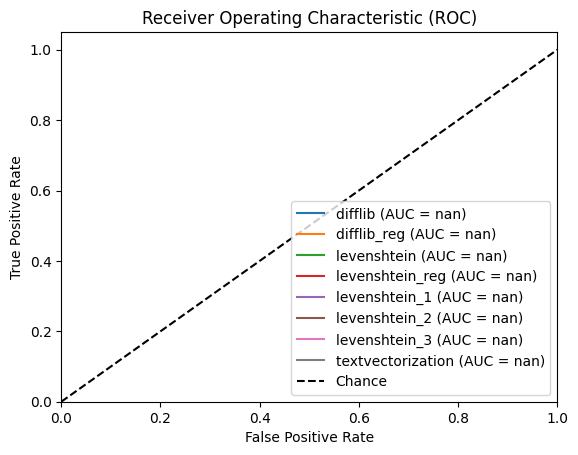

/home/erik/.python_env/ni_thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/erik/.python_env/ni_thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/erik/.python_env/ni_thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/erik/.python_env

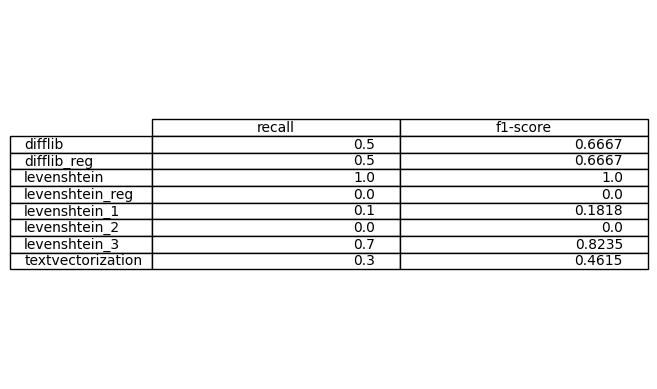

In [37]:
# load textvectorization model from dataset smaller_0.7

def eval_trained_models_on_handmade_data(suffix = '_data_smaller_0.7', DATASET = 'smaller_0.7', path=PATH_LABLED_SPLIT, known = True):
    X_train, y_train = read_and_split_data('train_data_', suffix)
    X_val, y_val = read_and_split_data('val_data_', suffix)
    X_test, y_test = read_and_split_data('test_data_', suffix)

    preprocess_student_pairs(X_train)
    preprocess_student_pairs(X_val)
    preprocess_student_pairs(X_test)

    model_names = ['difflib', 'difflib_reg', 'levenshtein', 'levenshtein_reg', 'levenshtein_1', 'levenshtein_2', 'levenshtein_3', 'textvectorization']
    test_predictions = pd.DataFrame(columns=model_names)
    textvectorization = tf.keras.models.load_model(THESIS_PATH+DATASET+'/textvectorization_model.tf')
    difflib_regressor = Difflib_Regressor()
    difflib_regressor.fit(X_train[['code1', 'code2']].values, y_train)
    difflib_regressor.fit(X_val[['code1', 'code2']].values, y_val)
    levenshtein_regressor = Levenshtein_Regressor()
    levenshtein_regressor.fit(X_train[['code1','code2']].values, y_train)
    levenshtein_regressor.fit(X_val[['code1','code2']].values, y_val)

    if(known):
        folder = 'known_tasks'
    else:
        folder = 'unknown_tasks'
    # create dataframe from handmade_plagiate
    df_handmade = pd.DataFrame()
    df_handmade['code1'] = [open(path+folder+'/handmade_plagiate_{}_0.c'.format(i), 'r').read() for i in range(0, 10)]
    df_handmade['code2'] = [open(path+folder+'/handmade_plagiate_{}_1.c'.format(i), 'r').read() for i in range(0, 10)]
    # shuffel the content of the columns
    for i in range(len(df_handmade)):
        if random.random() > 0.5:
            df_handmade.at[i, 'code1'], df_handmade.at[i, 'code2'] = df_handmade.at[i, 'code2'], df_handmade.at[i, 'code1']
    preprocess_student_pairs(df_handmade)
    df_handmade['label'] = 1
    # predict labels for all models
    test_predictions = test_all_models(df_handmade, test_predictions, df_handmade['label'], difflib_regressor, levenshtein_regressor, textvectorization)

    # calculate_confusion_matrix(test_predictions['textvectorization'].values, y_test, THESIS_PATH+DATASET+'/', 'textvectorization', f'test data set {DATASET}')
    df_metrics = calculate_metrics(df_handmade['label'], test_predictions, model_names)
    plot_metrics_table(df_metrics, THESIS_PATH + f'{DATASET}/', title=f'Metrics Table with handmade test data of {folder} trained on {DATASET}')

#
# TODO noch in jedem kapitel hinschreiben wie viele paare die verschiedenen daten enthalten
suffix = '_data_smaller_0.7'
DATASET = 'smaller_0.7'
eval_trained_models_on_handmade_data(suffix, DATASET, known=False)
